# Objective - NewYork City AirBnB Accomodation Price Prediction

## About

The New York City Airbnb Open Data is a public dataset and a part of Airbnb. It includes all needed information to find out more about hosts, geographical availability, necessary metrics to make predictions and draw conclusions. This dataset describes the listing activity and metrics in NYC, NY, for 2019.

In [362]:
import pandas as pd
import numpy as np

## Data Preparation & Loading

In [271]:
df = pd.read_csv("AB_NYC_2019.csv")
df = df.iloc[0:200]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              200 non-null    int64  
 1   name                            200 non-null    object 
 2   host_id                         200 non-null    int64  
 3   host_name                       200 non-null    object 
 4   neighbourhood_group             200 non-null    object 
 5   neighbourhood                   200 non-null    object 
 6   latitude                        200 non-null    float64
 7   longitude                       200 non-null    float64
 8   room_type                       200 non-null    object 
 9   price                           200 non-null    int64  
 10  minimum_nights                  200 non-null    int64  
 11  number_of_reviews               200 non-null    int64  
 12  last_review                     194 

## Feature Selection
### 1.1 ExtraTreesClassifier method
In this method, the ExtraTreesClassifier method will help to give the importance of each independent feature with a dependent feature. Feature importance will give you a score for each feature of your data, the higher the score more important or relevant to the feature towards your output variable.

In [296]:
df.shape
y = df.price
X = df.copy()
X = X.drop(["id", "host_id", "latitude", "longitude",  "price", "name", "host_name", "neighbourhood_group", "neighbourhood", "room_type"], axis='columns')
X.head()

,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,1,9,6,365
1,1,45,2,355
2,3,0,1,365
3,1,270,1,194
4,10,9,1,0


In [297]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X, y)
print(model.feature_importances_)

[0.23980006 0.3703052  0.07100307 0.31889166]


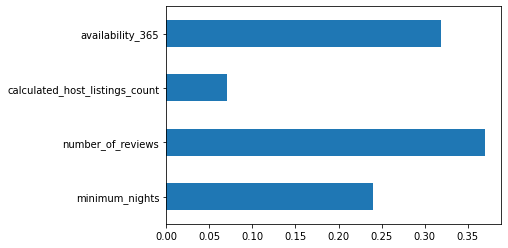

In [298]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.plot(kind="barh")
plt.show()

### 1.2 Univariate Selection
In this, Statistical tests can be used to select the independent features which have the strongest relationship with the dependent feature. SelectKBest method can be used with a suite of different statistical tests to select a specific number of features.


In [303]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
bestfeatures = SelectKBest(score_func=chi2, k=4)
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ["Specs", "Score"]
featureScores

,Specs,Score
0,minimum_nights,4623.972519
1,number_of_reviews,8347.932208
2,calculated_host_listings_count,77.502177
3,availability_365,6151.144083


## Data Cleaning: Handling NA values

In [274]:
df = df.drop(['last_review', 'reviews_per_month'], axis='columns')

In [276]:
df.isnull().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [278]:
df["room_type"].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

## Data Transformation

In [224]:
df["room_type"] = df["room_type"].apply(lambda x: x.title()) 

## Encoding & Adding new feature

In [318]:
room_list = df.room_type.unique().tolist()
room_dict = {v:k for k,v in enumerate(room_list, 1)}
df["room_enum"] = df["room_type"].apply(lambda x: room_dict[x])

In [315]:
neighbourhood_list = df.neighbourhood.unique().tolist()
neighbourhood_dict = {v:k for k, v in enumerate(neighbourhood_list)}

neighbourhood_group_list = df.neighbourhood_group.unique().tolist()
neighbourhood_group_dict = {v:k for k, v in enumerate(neighbourhood_group_list)}

df["neighbourhood_enum"] = df["neighbourhood"].apply(lambda x: neighbourhood_dict[x])
df["neighbourhood_group_enum"] = df["neighbourhood_group"].apply(lambda x: neighbourhood_group_dict[x])

In [257]:
df.head()

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_enum,neighbourhood_group_enum,room_enum
0,2539,2787,Brooklyn,Kensington,40.64749,-73.97237,Private Room,149,1,9,6,365,0,0,1
1,2595,2845,Manhattan,Midtown,40.75362,-73.98377,Entire Home/Apt,225,1,45,2,355,1,1,2
2,3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private Room,150,3,0,1,365,2,1,1
3,3831,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire Home/Apt,89,1,270,1,194,3,0,2
4,5022,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire Home/Apt,80,10,9,1,0,4,1,2


## Handling Outliers
### Before

In [306]:
df["minimum_nights"].describe()

count    197.000000
mean       6.700508
std        9.772235
min        1.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       60.000000
Name: minimum_nights, dtype: float64

In [305]:
factor = 3
nights_upper_limit = df["minimum_nights"].mean() + df["minimum_nights"].std() * factor
nights_lower_limit = df["minimum_nights"].mean() - df["minimum_nights"].std() * factor

df = df[(df["minimum_nights"] < nights_upper_limit) & (df["minimum_nights"] > nights_lower_limit)]
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


### After

In [307]:
df["minimum_nights"].describe()

count    197.000000
mean       6.700508
std        9.772235
min        1.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       60.000000
Name: minimum_nights, dtype: float64

In [309]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


## Grouping

Group dataset based on "room_type"

In [313]:
df.groupby("room_type").count()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
room_type,,,,,,,,,,,,,
Entire home/apt,100,100,100,100,100,100,100,100,100,100,100,100,100
Private room,96,96,96,96,96,96,96,96,96,96,96,96,96
Shared room,1,1,1,1,1,1,1,1,1,1,1,1,1


In [234]:
df.price.describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

## One Hot Encoding

In [316]:
dummies = pd.get_dummies(df.room_type)
dummies.head(3)

,Entire home/apt,Private room,Shared room
0,0,1,0
1,1,0,0
2,0,1,0


In [328]:
X = pd.concat([df["minimum_nights"], dummies], axis='columns')
X.head()

,minimum_nights,Entire home/apt,Private room,Shared room
0,1,0,1,0
1,1,1,0,0
2,3,0,1,0
3,1,1,0,0
4,10,1,0,0


In [329]:
y = df.price
y.head(3)

0    149
1    225
2    150
Name: price, dtype: int64

In [330]:
X.columns

Index(['minimum_nights', 'Entire home/apt', 'Private room', 'Shared room'], dtype='object')

In [361]:
X.shape

(197, 4)

## Split dataset into training and testing

In [331]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

## Build LinearRegression Model

In [332]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.3874579340927572

## Use K Fold cross validation to measure accuracy of our LinearRegression model

In [333]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.33546516, 0.30181633, 0.37401959, 0.36717543, 0.36939338])

## Find best model using GridSearchCV

In [334]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.349574,{'normalize': False}
1,lasso,0.376933,"{'alpha': 2, 'selection': 'cyclic'}"
2,decision_tree,0.258267,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


## Test model

In [353]:
def predict_price(room_type, nights):    
    loc_index = np.where(X.columns==room_type)[0]

    x = np.zeros(len(X.columns))
    x[0] = nights
    if loc_index.size >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])

In [358]:
predict_price("Private Room", 3)[0]

106.6935585958404

In [359]:
predict_price("Shared room", 5)[0]

35.53727829991625

In [360]:
predict_price("Entire home/apt", 6)[0]

190.1226077726074

## Saving the model

In [356]:
import pickle
with open('AirBnB-Rent-Prediction.pickle','wb') as f:
    pickle.dump(lr_clf,f)

## Save columns name

In [357]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))